In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay


# --- Limpieza de datos según lo indicado ---
df = pd.read_csv('titanic.csv')
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df = pd.get_dummies(df)
del df['Sex_female']
df['Age'] = df['Age'].fillna(df.Age.mean())

# Variables predictoras y variable objetivo
X = df.drop('Survived', axis=1)
y = df['Survived']

# --- División en conjunto de entrenamiento y test (80%-20%) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [2]:
# Crea un gradient boosting
# Crea un gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=4)
model.fit(X_train, y_train)
predicciones = model.predict_proba(X_test)[:,1]
roc_auc_score(y_score=predicciones, y_true=y_test)

0.8034255599472991

In [3]:
## Cross validation 
## Cross validation 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('gbt', GradientBoostingClassifier(n_estimators=300))
])

params = {
    'gbt__max_depth': [2,3,4,5],
    'gbt__learning_rate': [0.1, 0.5, 0.01]
}

grid_gbt =GridSearchCV(estimator=pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='roc_auc').fit(X_train, y_train)

In [4]:
# Mejor estimador 
grid_gbt.best_params_

{'gbt__learning_rate': 0.1, 'gbt__max_depth': 2}

In [5]:
# AUC
best_model = grid_gbt.best_estimator_.named_steps['gbt']
predicciones = best_model.predict_proba(X_test)[:,1]
roc_auc_score(y_score=predicciones, y_true=y_test)

0.7951910408432148

In [6]:
## Calibracion

In [10]:
# Entendiendo el modelo 
importancia = pd.DataFrame({
    'columna': X.columns,
    'importancia': best_model.feature_importances_
})
importancia.sort_values('importancia', ascending=False)
# porcentaje de veces que usas tu variable

,columna,importancia
5,Sex_male,0.476146
4,Fare,0.170174
1,Age,0.154670
0,Pclass,0.148288
2,SibSp,0.025404
8,Embarked_S,0.017632
3,Parch,0.007544
7,Embarked_Q,0.000134
6,Embarked_C,0.000010


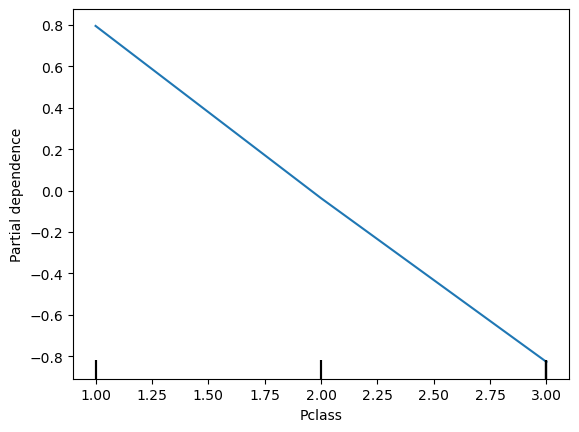

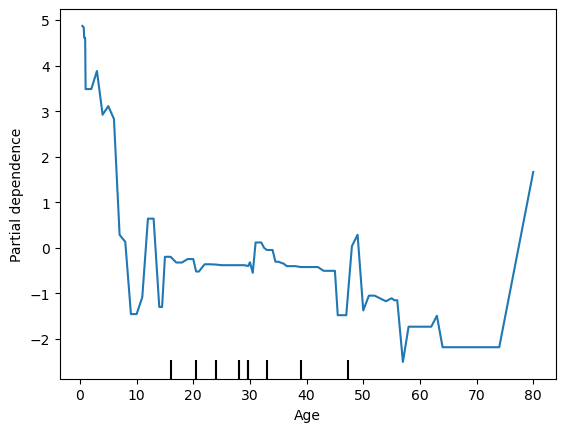

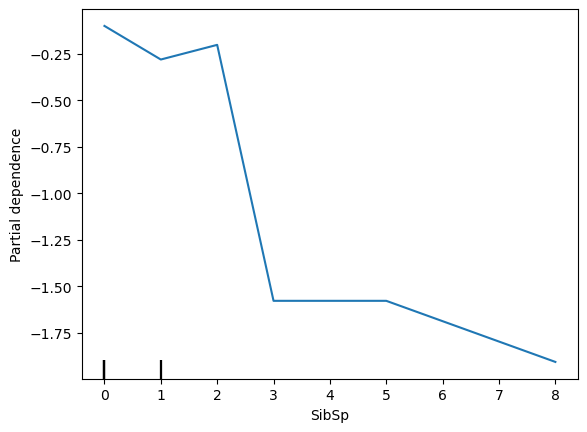

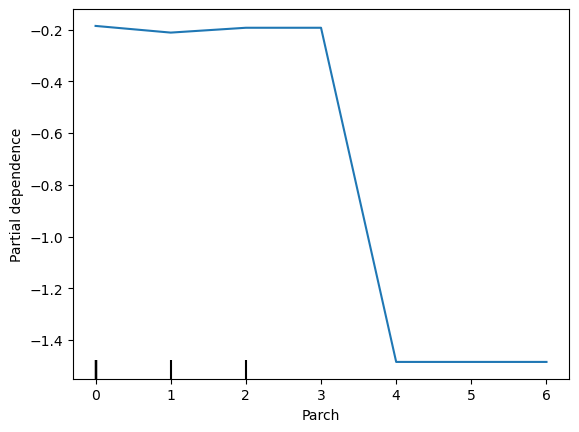

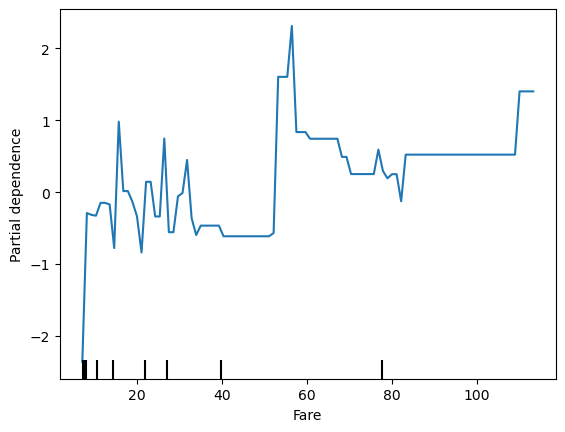

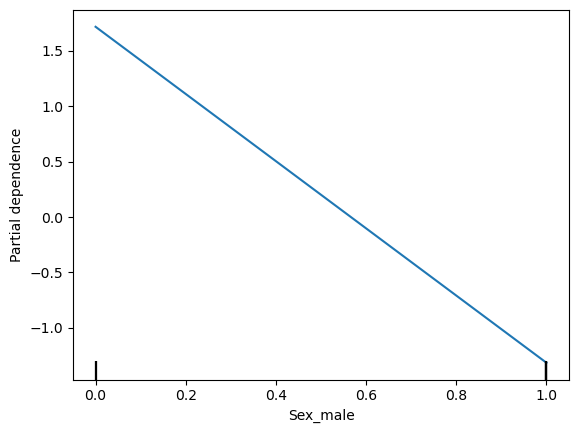

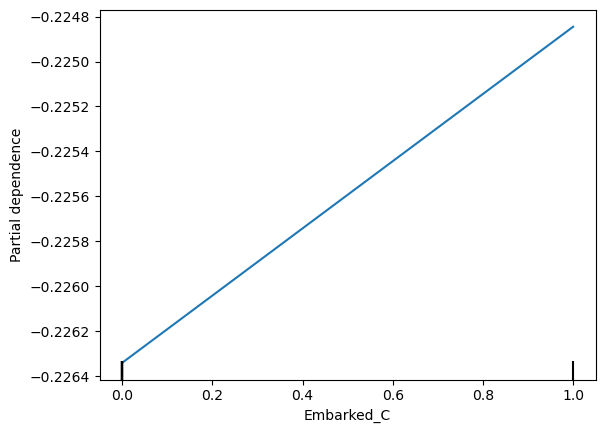

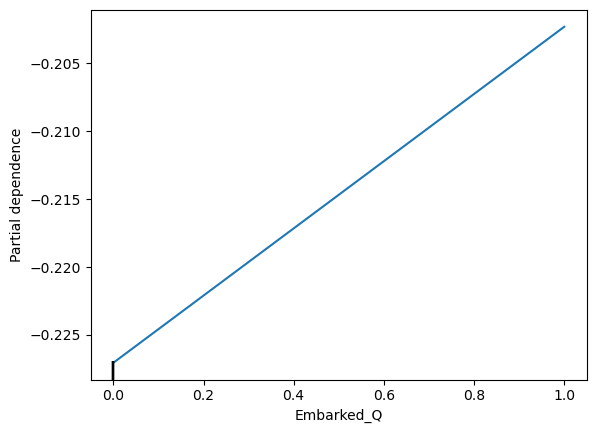

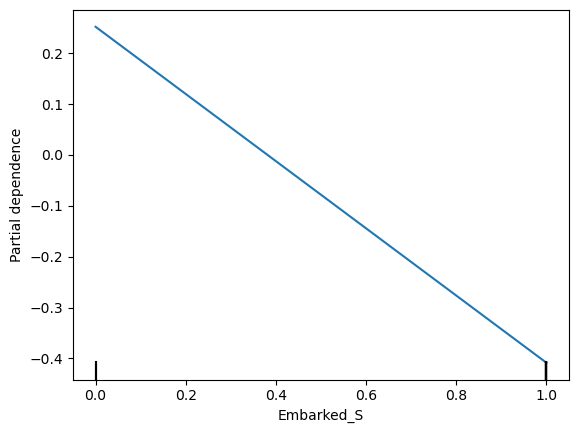

In [11]:
# Codigo for para partial dependence plot 

for i in range(len(X_train.columns)):
    PartialDependenceDisplay.from_estimator(
        best_model, 
        X_train, 
        [i],
        feature_names=X_train.columns
    )

Fijas la variable para todos y ves que pasa con el promedio de los log_odds